# Supervised Learning with AMEX Data
## American Express - Default Prediction

* This notebook consist in an exploratory analysis from Amex data with Dask.

In [2]:
import re
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
client = Client(n_workers=4)
client

/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:366: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:366: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:366: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


Client Scheduler: tcp://127.0.0.1:54499 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [3]:
df = dd.read_csv('/Users/usuario/workspace/AMEX_data/train_data.csv',)

In [4]:
df.head(3)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603


The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables

In [5]:
string = str(' '.join((df.columns)))
Delinquency_columns = re.findall(r'(D_\d*)', string)
Spend_columns = re.findall(r'(S_\d*)', string)
Payment_columns = re.findall(r'(P_\d*)', string)
Balance_columns = re.findall(r'(B_\d*)', string)
Risk_Columns = re.findall(r'(R_\d*)', string)


In [6]:
print(f'Hay {len(Delinquency_columns)} variables sobre delincuencia')
print(f'Hay {len(Spend_columns)} variables sobre gastos')
print(f'Hay {len(Payment_columns)} variables sobre pagos')
print(f'Hay {len(Balance_columns)} variables sobre balances')
print(f'Hay {len(Risk_Columns)} variables sobre riesgo')

Hay 96 variables sobre delincuencia
Hay 22 variables sobre gastos
Hay 3 variables sobre pagos
Hay 40 variables sobre balances
Hay 28 variables sobre riesgo


# Reducir los datatypes
Cambiaremos los tipos de archivos de las colúmnas para reducir el tamaño del dataset

In [54]:
from sys import getsizeof
start_size = getsizeof(df.compute())/(1024.0**3)
print('Dataframe size: %2.2f GB'%start_size)

Dataframe size: 9.01 GB


In [59]:
df.dtypes.value_counts()

float64           185
object              3
datetime64[ns]      1
int64               1
dtype: int64

## Cambiando el tipo de datos de la columna customer_ID

In [15]:
%%timeit
pd_df_ID = df['customer_ID']

249 µs ± 43.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
ID = pd_df_ID.compute()

In [21]:
#We transform the column data type of customer_ID from 64 bytes per row to 8 bytes
ID =\
    ID.apply(lambda x: int(x[-16:],16) ).astype('int64')

Text(0, 0.5, 'Frecuencia')

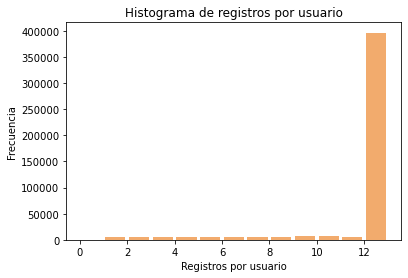

In [34]:
import matplotlib.pyplot as plt
n_casos = [x for x in range(14)]
plt.hist(x=ID.value_counts(), bins=n_casos, color='#F2AB6D', rwidth=0.85)
plt.title('Histograma de registros por usuario')
plt.xlabel('Registros por usuario')
plt.ylabel('Frecuencia')

Hay 13 observaciones para la mayor parte de los usuarios

# Column S_2 
* Reduce 10 bytes to 3 bytes

In [48]:
df['S_2'] = dd.to_datetime(df['S_2'])

In [49]:
df['S_2'].compute()

0      2017-03-09
1      2017-04-07
2      2017-05-28
3      2017-06-13
4      2017-07-16
          ...    
3125   2017-11-05
3126   2017-12-23
3127   2018-01-06
3128   2018-02-06
3129   2018-03-14
Name: S_2, Length: 5531451, dtype: datetime64[ns]

# Categorical Columns 
* Reduce 88 bytes to 11 bytes

The 11 columns ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'] are categorical with maximum 8 values. Therefore each of these columns can be converted into int8 which is 1 byte per row. Originally they are each 8 bytes per row.